# Modéliser la ponctualité des trains du Transilien

Olivier Viollet, Avril 2019, olivier.viollet[a]gmail.com

## Résumé

Cette étude crée une modélisation de la ponctualité des trains du Transilien, avec une erreur moyenne absolue de 3,3 points de pourcentage.

Plan :

1. Objectif, préparation et exploration des données
2. Modéliser la ponctualité
3. Evaluer la précision de la modélisation

## 1. Objectif, préparation et exploration des données

Nous cherchons dans cette étude à utiliser les données collectées entre 2013 et 2018 relatives à la ponctualité des trains du réseau Transilien afin de construire un modèle capable de prédire aussi précisément que possible le degré de ponctualité d'un train donné à partir de certaines de ses caractéristiques. Un tel modèle pourrait être utile à l'entreprise afin, par exemple, d'optimiser l'utilisation de ses ressources pour améliorer la ponctualité de ses trains. Le **taux de ponctualité** est défini par la SNCF comme le "pourcentage de voyageurs arrivant avec un retard de moins de cinq minutes à leur gare de destination".

Les données ont été mises à disposition par la SNCF sur sa plateforme d'ouverture de données, SNCF Open Data. Elles sont accessibles à l'adresse suivante : https://ressources.data.sncf.com/explore/dataset/ponctualite-mensuelle-transilien/information/?sort=date

Le jeu de données, dans son état au 27 février 2019, comprend 935 observations après le retrait d'une observation dont la valeur cible - le taux de ponctualité - est manquante. Les variables prédictives sont :

- la date ;
- le type de service (RER ou Transilien) ;
- la ligne.

Nous extrayons les deux seules informations possibles à partir de la date : le mois et l'année. Le jeu de données ne nécessite pas d'autre préparation.

Une exploration sommaire des données fait émerger les constats suivants :

- la ponctualité, pour 50 % des observations, est comprise entre 85,5 % et 92,6 % des voyageurs, ce qui signifie une forte concentration des valeurs, confirmée par un écart-type de seulement 5,9 ;
- la ponctualité est globalement meilleure sur le Transilien que sur le RER, d'autant que c'est sur ce dernier que l'on retrouve les quelques cas de très fort manquement à la ponctualité, hormis une exception sur le Transilien ;
- en lien avec le précédent constat, la ponctualité la plus faible provient de la ligne A ;
- le taux médian de ponctualité n'a pas beacoup évolué entre 2013 et 2018, mais il convient de noter que l'année 2016 a été marquée par un plus grand nombre de manquements importants à la ponctualité ;
- la ponctualité est sensiblement plus faible en milieu et fin d'année.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# fonction de recodage
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [3]:
transilien = pd.read_csv('ponctualite-mensuelle-transilien.csv', usecols = [1,2,3,5], sep = ';', encoding = 'utf-8')
print(transilien.info()) # une valeur manquante dans la cible
transilien.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 4 columns):
Date                   936 non-null object
Service                936 non-null object
Ligne                  936 non-null object
Taux de ponctualité    935 non-null float64
dtypes: float64(1), object(3)
memory usage: 29.3+ KB
None


,Date,Service,Ligne,Taux de ponctualité
0,2013-02,Transilien,H,92.700000
1,2013-02,Transilien,R,88.200000
2,2013-02,Transilien,P,89.400000
3,2013-01,Transilien,P,85.800000
4,2013-02,RER,E,94.700000
5,2013-01,RER,B,80.100000
6,2013-01,RER,A,83.600000
7,2015-02,Transilien,U,91.446172
8,2015-03,Transilien,U,95.922037
9,2015-02,Transilien,J,85.058236


count    935.000000
mean      88.184163
std        5.884123
min       58.100000
25%       85.500000
50%       89.200000
75%       92.600000
max       97.600000
Name: Taux de ponctualité, dtype: float64


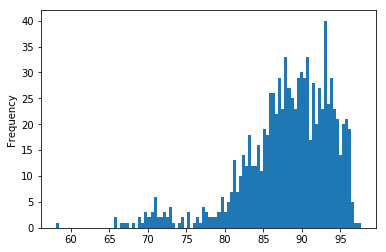

In [4]:
transilien = transilien[np.isfinite(transilien['Taux de ponctualité'])]
print(transilien['Taux de ponctualité'].describe())
transilien['Taux de ponctualité'].plot.hist(100)

In [5]:
transilien['Date'] = pd.to_datetime(transilien['Date'], utc = True)
transilien['Année'] = transilien['Date'].dt.year
pd.value_counts(transilien.Année)

2018    156
2017    156
2016    156
2015    156
2013    156
2014    155
Name: Année, dtype: int64

In [6]:
transilien['Mois'] = transilien['Date'].dt.month
transilien['Mois'] = transilien['Mois'].astype('category')
transilien.drop(columns = ['Date'], inplace=True)

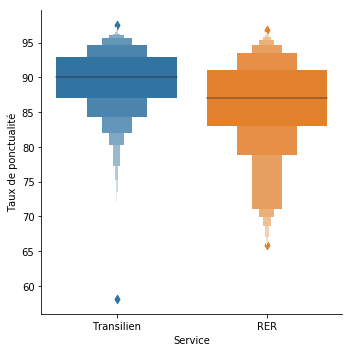

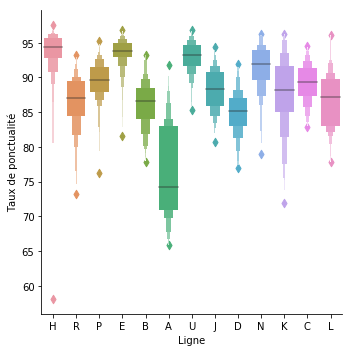

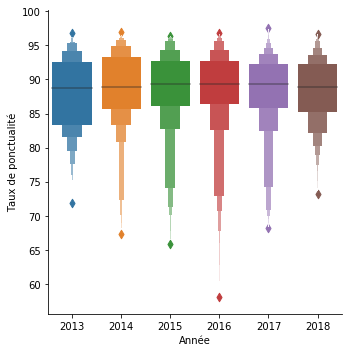

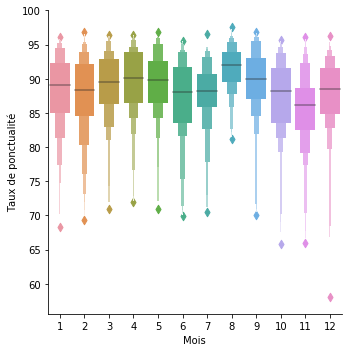

In [7]:
sns.catplot(x = 'Service', y = 'Taux de ponctualité', kind = 'boxen', data = transilien)
sns.catplot(x = 'Ligne', y = 'Taux de ponctualité', kind = 'boxen', data = transilien)
sns.catplot(x = 'Année', y = 'Taux de ponctualité', kind = 'boxen', data = transilien)
sns.catplot(x = 'Mois', y = 'Taux de ponctualité', kind = 'boxen', data = transilien)

In [8]:
transilien.info()
transilien.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 935
Data columns (total 5 columns):
Service                935 non-null object
Ligne                  935 non-null object
Taux de ponctualité    935 non-null float64
Année                  935 non-null int64
Mois                   935 non-null category
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 77.8+ KB


,Service,Ligne,Taux de ponctualité,Année,Mois
0,Transilien,H,92.700000,2013,2
1,Transilien,R,88.200000,2013,2
2,Transilien,P,89.400000,2013,2
3,Transilien,P,85.800000,2013,1
4,RER,E,94.700000,2013,2
5,RER,B,80.100000,2013,1
6,RER,A,83.600000,2013,1
7,Transilien,U,91.446172,2015,2
8,Transilien,U,95.922037,2015,3
9,Transilien,J,85.058236,2015,2


## 2. Modéliser la ponctualité

### Jeux de données et mesure de performance

Trois jeux de données sont créés à partir du jeu initial : 
- un jeu de **test**, qui correspond à l'année 2018 ; 
- un jeu de **validation**, qui correspond à l'année 2017 ;
- un jeu d'**entrainement**, pour les années 2013-2016.

En effet, dès lors que le jeu de données comporte une dimension temporel, il convient de ne pas créer les jeux de données de manière aléatoire, puisque l'objectif réel du modèle est de prédire la ponctualité durant les prochaines années.

La mesure de performance retenue ici est l'**erreur moyenne absolue**.

In [9]:
# test
test = transilien[transilien['Année'] == 2018]
y_test = test['Taux de ponctualité']
test.drop(columns = ['Taux de ponctualité'], inplace=True)
X_test = pd.get_dummies(test)

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
# validation 
validation = transilien[transilien['Année'] == 2017]
y_val = validation['Taux de ponctualité']
validation.drop(columns = ['Taux de ponctualité'], inplace=True)
X_val = pd.get_dummies(validation)

In [11]:
# entrainement 
training = transilien[transilien['Année'] != 2017]
training = training[training['Année'] != 2018]
y_train = training['Taux de ponctualité']
training.drop(columns = ['Taux de ponctualité'], inplace=True)
X_train = pd.get_dummies(training)

### Résultats des modèles

La manière la plus simple de prédire le taux de ponctualité serait de **prédire la moyenne ou la médiane** des observations passées pour chacune des observations futures. Dans ce cas, l'erreur moyenne absolue avoisine **4.4 points de pourcentage**, ce qui constitue un repère pour comparer la performance des modélisations plus sophistiquées.

Ainsi, l'erreur moyenne de la **régression linéaire** s'élève à **3.2 points**, que l'on prenne la valeur brute ou le logarithme naturel de la variable cible.

La **forêt aléatoire**, après mesures de régularisation pour réduire le sur-apprentissage, commet une erreur moyenne de **2.7 points**. 

Enfin, le ***light gradient boosting machine*** réalise les meilleures prédictions puisque son erreur moyenne tombe à **2.4 points**.

In [14]:
# prédictions simples
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
print(y_train.describe())
y_val['predictions_mean'] = 88.2 # prédire la moyenne pour toutes les observations
y_val['predictions_median'] = 89.1 # prédire la médiane pour toutes les observations
print(mean_absolute_error(y_val['Taux de ponctualité'], y_val['predictions_mean']))
print(mean_absolute_error(y_val['Taux de ponctualité'], y_val['predictions_median']))

       Taux de ponctualité
count           623.000000
mean             88.221322
std               6.037617
min              58.100000
25%              85.500000
50%              89.100000
75%              92.793089
max              96.900000
4.480744915950632
4.387485905425316


In [16]:
# recréer le jeu de validation
validation = transilien[transilien['Année'] == 2017]
y_val = validation['Taux de ponctualité']
validation.drop(columns = ['Taux de ponctualité'], inplace=True)
X_val = pd.get_dummies(validation)

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Régression linéaire

In [17]:
# régression linéaire
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
print('Erreur moyenne sur le jeu d\'entrainement : ', mean_absolute_error(y_train, y_train_pred)) # 2.4

y_val_pred = reg.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, y_val_pred)) # 3.2

Erreur moyenne sur le jeu d'entrainement :  2.436458702798556
Erreur moyenne sur le jeu de validation :  3.1882159867576925


In [18]:
    # régression linéaire avec le logarithme naturel
y_train_log = y_train + 0.1
y_train_log = np.log(y_train_log)
reg_log = LinearRegression().fit(X_train, y_train_log)
y_train_pred = reg_log.predict(X_train)
print('Erreur moyenne sur le jeu d\'entrainement : ', mean_absolute_error(y_train, np.exp(y_train_pred))) # 2.4

y_val_pred = reg_log.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val,np.exp(y_val_pred))) # 3.2

Erreur moyenne sur le jeu d'entrainement :  2.457060043002903
Erreur moyenne sur le jeu de validation :  3.1863912355016777


#### Forêt aléatoire

In [19]:
# forêt aléatoire
forest = RandomForestRegressor(criterion = 'mae',random_state = 1, n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_val_pred = forest.predict(X_val)

print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 0.8
print("Erreur moyenne sur le jeu de validation : ", mean_absolute_error(y_val, y_val_pred)) # 2.9

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Erreur moyenne sur le jeu d'entrainement :  0.8270999704741564
Erreur moyenne sur le jeu de validation :  2.8694537128339745


In [20]:
forest = RandomForestRegressor(criterion = 'mae', min_samples_split=5, max_features = 0.6, max_depth =16,
                               random_state = 1, n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_val_pred = forest.predict(X_val)

print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 1.4
print("Erreur moyenne sur le jeu de validation : ", mean_absolute_error(y_val, y_val_pred)) # 2.7

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Erreur moyenne sur le jeu d'entrainement :  1.4531355218848236
Erreur moyenne sur le jeu de validation :  2.6980825149144243


#### Light gradient boosting machine

In [21]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

d_train = lgb.Dataset(X_train, label = y_train["Taux de ponctualité"])

In [22]:
clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 1.7

y_val_pred = clf.predict(X_val)
print('Erreur moyenne sur le jeu de validation : ', mean_absolute_error(y_val, y_val_pred)) # 2.4

Erreur moyenne sur le jeu d'entrainement :  1.7312601039649245
Erreur moyenne sur le jeu de validation :  2.454312035258635


## 3. Evaluer la précision de la modélisation

Afin d'évaluer la capacité de généralisation des modèles, un jeu d'entrainement final est recréé, comprenant le jeu d'entrainement ci-dessus ainsi que le jeu ayant servi à la validation ; autrement dit, toutes les années antérieures à 2018, laquelle est dédiée au test.

Reprenant les hyperparamètres des modèles ci-dessus, et les entrainant une dernière fois sur le jeu d'entrainement, il apparait que la performance globale des trois algorithmes est identique, avec une erreur moyenne absolue d'environ **3.3 points de pourcentage**, même si les modèles commettent, dans le détail, des erreurs différentes. Cela signifie que si, pour une observation donnée, à partir des variables explicatives, le modèle prédit - par exemple - "90", le taux réel de ponctualité sera en moyenne compris entre 86.7 % et 93.3 % ; il peut excéder ces bornes, auquel cas l'erreur commise sur une autre observation sera moindre.

Les modèles les plus simples étant les plus aisés à déployer en production, il peut être recommandé d'utiliser la **régression linéaire**, sans besoin de transformer la variable cible.

In [23]:
# jeu complet d'entrainement 
training = transilien[transilien['Année'] != 2018]
y_train = training['Taux de ponctualité']
training.drop(columns = ['Taux de ponctualité'], inplace=True)
X_train = pd.get_dummies(training)

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Régression linéaire

In [24]:
    # régression linéaire
reg = LinearRegression().fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
print('Erreur moyenne sur le jeu d\'entrainement : ', mean_absolute_error(y_train, y_train_pred)) # 2.6

y_test_pred = reg.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test,y_test_pred)) # 3.3

Erreur moyenne sur le jeu d'entrainement :  2.5776209400624364
Erreur moyenne sur le jeu de test :  3.254712982396139


#### Forêt aléatoire

In [25]:
forest = RandomForestRegressor(criterion = 'mae', min_samples_split=5, max_features = 0.6, max_depth =16,
                               random_state = 1, n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 1.5
print("Erreur moyenne sur le jeu de test : ", mean_absolute_error(y_test, y_test_pred)) # 3.3

C:\Users\olivi\Anaconda3\envs\dl\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Erreur moyenne sur le jeu d'entrainement :  1.54210697852387
Erreur moyenne sur le jeu de test :  3.3388762675767296


In [26]:
# importance des variables
pd.DataFrame({'Variable':pd.DataFrame(X_test).columns,'Importance':forest.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
3,Ligne_A,0.183504
0,Année,0.136840
8,Ligne_H,0.084389
7,Ligne_E,0.082415
15,Ligne_U,0.058875
12,Ligne_N,0.047011
23,Mois_8,0.046355
26,Mois_11,0.037938
20,Mois_5,0.025990
21,Mois_6,0.023749


#### Light gradient boosting machine

In [27]:
# light GBM 
y_train = pd.DataFrame(y_train)

params = {"objective" : "regression",
          "metric" : "mae",
          'boosting_type' : 'gbdt',
          "num_leaves" : 30,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.7,
          "feature_fraction" : 0.7,
          "bagging_seed" : 420,
          "verbosity" : -1}

d_train = lgb.Dataset(X_train, label = y_train["Taux de ponctualité"])

clf = lgb.train(params, d_train, 100)
y_train_pred = clf.predict(X_train)
print("Erreur moyenne sur le jeu d\'entrainement : ", mean_absolute_error(y_train, y_train_pred)) # 1.7

y_test_pred = clf.predict(X_test)
print('Erreur moyenne sur le jeu de test : ', mean_absolute_error(y_test, y_test_pred)) # 3.3

Erreur moyenne sur le jeu d'entrainement :  1.7393162749281583
Erreur moyenne sur le jeu de test :  3.2790448455495396


In [28]:
# importance des variables
pd.DataFrame(sorted(zip(clf.feature_importance(),X_test.columns)), 
             columns=['Importance','Variable']).sort_values('Importance', ascending=False)

,Importance,Variable
27,718,Année
26,219,Service_RER
25,70,Ligne_K
24,68,Mois_8
23,64,Ligne_R
22,64,Ligne_A
21,61,Service_Transilien
20,59,Mois_12
19,55,Ligne_H
18,55,Ligne_E
